---
title: "Synaptic Connectivity"
format: 
    html:
        toc: true 
        code-fold: false
        code-links:
          - text: Download Quickstart Notebooks
            icon: file-code
            href: https://github.com/AllenInstitute/microns_tutorial/tree/main/tutorial_book/quickstart_notebooks
execute:
    eval: False
    warning: False
jupyter: python3
---

The **Connectome Annotation Versioning Engine (CAVE)** is a suite of tools developed at the Allen Institute and Seung Lab to manage large connectomics data.  

::: {.callout-important}
## Initial Setup
Before using any programmatic access to the data, [you first need to set up your CAVEclient token](em_py_01_caveclient_setup.html).
:::

The connectome data (synapses, cell types, etc.) can be accessed from the cloud via CAVE. However, because of the size of the connectivity tables, it is often preferable to download and compile the features of interest (in this case synapses) to work with offline. This notebook steps through downloading the synapses of the proofread neurons, as of materialization version 1181.  

::: {.callout-tip}
## Quickstart
It is recommended you have worked through the [CAVE Quickstart](em_py_02_cave_quickstart.html) notebook, as this tutorial builds on knowledge in the previous notebook.
:::

In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Initialize CAVEclient with a datastack
    
Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for MICrONS public release is `minnie65_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.   
    

In [2]:
client = CAVEclient("minnie65_public")

## Materialization versions

Data in CAVE is timestamped and periodically versioned - each (materialization) version corresponds to a specific timestamp. Individual versions are made publicly available. The materialization service provides annotation queries to the dataset. It is available under `client.materialize`.

Currently the following versions are publicly available (in this tutorial we will be using 1181):



In [3]:
client.materialize.get_versions()

[1078, 117, 661, 343, 1181, 795, 943]

And these are their associated timestamps (all timestamps are in UTC):



In [4]:
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

Version 1078: 2024-06-05 10:10:01.203215+00:00
Version 117: 2021-06-11 08:10:00.215114+00:00
Version 661: 2023-04-06 20:17:09.199182+00:00
Version 343: 2022-02-24 08:10:00.184668+00:00
Version 1181: 2024-09-16 10:10:01.121167+00:00
Version 795: 2023-08-23 08:10:01.404268+00:00
Version 943: 2024-01-22 08:10:01.497934+00:00


The client will automatically query the latest materialization version. You can specify a `materialization_version` for every query if you want to access a specific version.



In [5]:
client.version=1181

## Querying Synapses

While synapses are stored as any other table in the database, in this case `synapses_pni_2`, this table is much larger than any other table at more than 337 million rows, and it works best when queried in a different way.

The `synapse_query` function allows you to query the synapse table in a more convenient way than most other tables.
In particular, the `pre_ids` and `post_ids` let you specify which root id (or collection of root ids) you want to query, with pre_ids indicating the collection of presynaptic neurons and post_ids the collection of postsynaptic neurons.

Using both `pre_ids` and `post_ids` in one call is effectively a logical AND, returning only those synapses from neurons in the list of `pre_ids` that target neurons in the list of `post_ids`.

Let's look at one particular example.

In [6]:
my_root_id = 864691135808473885
syn_df = client.materialize.synapse_query(pre_ids=my_root_id)
print(f"Total number of output synapses for {my_root_id}: {len(syn_df)}")
syn_df.head()

Total number of output synapses for 864691135808473885: 1498


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,158405512,2020-11-04 06:48:59.403833+00:00,NaN,t,420,89385416926790697,864691135808473885,89385416926797494,864691135546540484,"[179076, 188248, 20233]","[179156, 188220, 20239]","[179140, 188230, 20239]"
1,185549462,2020-11-04 06:49:10.903020+00:00,NaN,t,4832,91356016507479890,864691135808473885,91356016507470163,864691135884799088,"[193168, 190452, 19262]","[193142, 190404, 19257]","[193180, 190432, 19254]"
2,138110803,2020-11-04 06:49:46.758528+00:00,NaN,t,3176,87263084540201919,864691135808473885,87263084540199587,864691135759983182,"[163440, 104292, 19808]","[163498, 104348, 19806]","[163460, 104356, 19804]"
3,157378264,2020-11-04 07:38:27.332669+00:00,NaN,t,412,89374490395905686,864691135808473885,89374490395921430,864691135446953106,"[179218, 107132, 19372]","[179204, 107010, 19383]","[179196, 107072, 19380]"
4,174798776,2020-11-04 10:10:59.416878+00:00,NaN,t,1796,90089104301487245,864691135808473885,90089104301487089,864691135572292333,"[184038, 188292, 19753]","[183920, 188202, 19754]","[183998, 188216, 19755]"


Note that synapse queries always return the list of every synapse between the neurons in the query, even if there are multiple synapses between the same pair of neurons.

A common pattern to generate a list of connections between unique pairs of neurons is to group by the root ids of the presynaptic and postsynaptic neurons and then count the number of synapses between them.
For example, to get the number of synapses from this neuron onto every other neuron, ordered

In [7]:
syn_df.groupby(
  ['pre_pt_root_id', 'post_pt_root_id']
).count()[['id']].rename(
  columns={'id': 'syn_count'}
).sort_values(
  by='syn_count',
  ascending=False,
)
# Note that the 'id' part here is just a way to quickly extract one column.
# This could be any of the remaining column names, but `id` is often convenient 
# because it is common to all tables.

syn_count
pre_pt_root_id     post_pt_root_id              
864691135808473885 864691135865557118         20
                   864691135214122296         16
                   864691136578647572         15
                   864691136066504856         13
                   864691135841325283         11
...                                          ...
                   864691136926552138          1
                   864691136952088543          1
                   864691135241125665          1
                   864691136952690399          1
                   864691136974682652          1

[1035 rows x 1 columns]

We can query the synapse table directly. However, it is too large to query all at once. CAVE limits to queries to 500,000 rows at once and will display a warning when that happens. Here, we demonstrate this with the limit set to 10:

In [8]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, limit=10, desired_resolution=[1, 1, 1], split_positions=True)
syn_df

201 - "Limited query to 10 rows


,id,created,superceded_id,valid,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id
0,4456,2020-11-04 13:02:08.388988+00:00,NaN,t,211448.0,409744.0,801440.0,211448.0,409744.0,801440.0,211612.0,410172.0,801400.0,2956,72063160986635724,864691135533713769,72063160986635724,864691135533713769
1,4503,2020-11-04 12:09:33.286834+00:00,NaN,t,212456.0,408032.0,800360.0,212456.0,408032.0,800360.0,212168.0,408088.0,800400.0,344,72063092267156962,864691135087527094,72063092267156962,864691135087527094
2,4508,2020-11-04 13:02:13.024144+00:00,NaN,t,212448.0,411696.0,801440.0,212448.0,411696.0,801440.0,212224.0,411800.0,801560.0,344,72063229706111827,864691135533713769,72063229706111827,864691135533713769
3,4568,2020-11-04 13:44:08.085705+00:00,NaN,t,213392.0,415448.0,802920.0,213392.0,415448.0,802920.0,213096.0,415176.0,802880.0,13816,72133735889250131,864691134530418554,72133735889250131,864691134530418554
4,4581,2020-11-04 07:29:12.917622+00:00,NaN,t,213552.0,417184.0,800800.0,213552.0,417184.0,800800.0,213240.0,417080.0,801080.0,10436,72133804608718799,864691134745062676,72133804608718799,864691134745062676
5,4582,2020-11-04 13:02:17.694701+00:00,NaN,t,212880.0,409120.0,801440.0,212880.0,409120.0,801440.0,213016.0,408832.0,801520.0,1344,72063160986636743,864691135533713769,72063160986636743,864691135533713769
6,4588,2020-11-04 12:20:12.290593+00:00,NaN,t,213200.0,421120.0,805520.0,213200.0,421120.0,805520.0,213064.0,421000.0,805600.0,7128,72133942047682150,864691134609767690,72133942047682150,864691134609767690
7,4590,2020-11-04 13:20:01.875310+00:00,NaN,t,213504.0,406440.0,805160.0,213504.0,406440.0,805160.0,213336.0,406596.0,805200.0,6572,72133461011344162,864691135091400630,72133461011344162,864691135091400630
8,4606,2020-11-04 07:24:39.038223+00:00,NaN,t,213384.0,413792.0,800800.0,213384.0,413792.0,800800.0,213256.0,413976.0,801040.0,2100,72133667169766499,864691134609872906,72133667169766499,864691134609872906
9,4611,2020-11-04 07:24:37.800341+00:00,NaN,t,213336.0,415304.0,800960.0,213336.0,415304.0,800960.0,213192.0,415604.0,800960.0,492,72133735889243887,864691134609872906,72133735889243887,864691134609872906


Instead we need to limit our query to a few neurons. The next section will load the proofread cells, and merge their cell type information for some connectivity mapping

## Query proofread cells and connectivity

### Proofread neurons

The table `proofreading_status_and_strategy` contains proofreading information about ~1,300 neurons. <a href=https://www.microns-explorer.org/manifests/mm3-proofreading>This manifest on microns-explorer.org</a> provides the most detailed overview. In brief, axons annotated with any `strategy_axon` were cleaned of false mergers but not all were fully extended. The most important distinction is axons annotated with `axon_column_truncated` were only proofread within a certain volume wheras others were proofread without such bias. 

In [9]:
proof_df = client.materialize.tables.proofreading_status_and_strategy(status_axon='t').query(desired_resolution=[1, 1, 1], split_positions=True)
proof_df["strategy_axon"].value_counts()

Table Owner Notice on proofreading_status_and_strategy: NOTE: this table supercedes 'proofreading_status_public_release'. For more details, see: www.microns-explorer.org/manifests/mm3-proofreading.


strategy_axon
axon_partially_extended    979
axon_column_truncated      233
axon_interareal            144
axon_fully_extended         80
Name: count, dtype: int64

### Query synapses between proofread neurons

We can query the graph spanned by the neurons with proofread axons using the `filter_in_dict` parameter (takes ~3 mins):

In [10]:
%%time 
# This takes 3-5 minutes to complete

synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_proof_only_df = client.materialize.query_table(synapse_table_name, desired_resolution=[1, 1, 1], split_positions=True,
                                                   filter_in_dict={"pre_pt_root_id": proof_df["pt_root_id"], 
                                                                   "post_pt_root_id": proof_df["pt_root_id"]})

# remove autapses
syn_proof_only_df = syn_proof_only_df[syn_proof_only_df["pre_pt_root_id"] != syn_proof_only_df["post_pt_root_id"]]
print(len(syn_proof_only_df))

132438
CPU times: total: 297 ms
Wall time: 2min 23s


### Plot connectivity as binarized heatmap
Now lets plot the connectivity between every proofread cell and every other cell

In [11]:
syn_mat = syn_proof_only_df.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                      values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)
syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

<Axes: xlabel='post_pt_root_id', ylabel='pre_pt_root_id'>

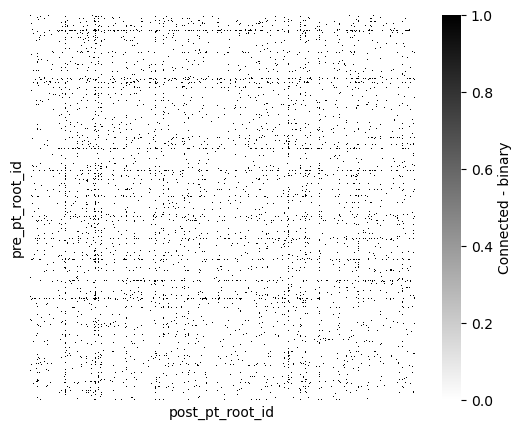

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(syn_mat, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})

There is some structure of highly interconnected cells. By adding information about the type of cells, we might infer more about the connectivity patterns

## Add cell type information to connectivity

### Querying cell type information 

There are two distinct ways cell types were classified in the MICrONS dataset: manual and automated. Manual annotations are available for ~1,000 neurons (`allen_v1_column_types_slanted_ref`), automated classifications are available for all cell bodies based on these manual annotations (`aibs_metamodel_celltypes_v661`). Because they are annotating an existing annotations, these annotations are introduced as a "reference" table:

::: {.callout-tip}
## Annotation tables
For more on cell types and their tables, see the [Annotation Tables](/programmatic_access/em_py_03_annotation_tables.html) page.
:::

In [13]:
ct_manual_df = client.materialize.query_table("allen_v1_column_types_slanted_ref", desired_resolution=[1, 1, 1], split_positions=True)

# rename the reference column for clarity
ct_manual_df.rename(columns={'target_id': 'nucleus_id'}, inplace=True)

# remove segments with multiple cell bodies
ct_manual_df.drop_duplicates("pt_root_id", keep=False, inplace=True)
ct_manual_df.head(5)

,id,created,valid,nucleus_id,classification_system,cell_type,id_ref,created_ref,valid_ref,volume,...,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,50,2023-03-18 14:13:21.613360+00:00,t,258319,aibs_coarse_excitatory,23P,258319,2020-09-28 22:40:42.476911+00:00,t,261.806162,...,572992.0,849520.0,NaN,NaN,NaN,NaN,NaN,NaN,89309001002848425,864691135927260174
1,1119,2023-03-18 14:13:22.506660+00:00,t,276438,aibs_coarse_excitatory,6P-CT,276438,2020-09-28 22:40:42.700226+00:00,t,277.317714,...,1035072.0,943880.0,NaN,NaN,NaN,NaN,NaN,NaN,89465269428261699,864691136487559186
2,35,2023-03-18 14:13:21.602813+00:00,t,260552,aibs_coarse_excitatory,23P,260552,2020-09-28 22:40:42.745779+00:00,t,230.111805,...,631872.0,840080.0,NaN,NaN,NaN,NaN,NaN,NaN,89170256379033022,864691135510274057
3,95,2023-03-18 14:13:21.644304+00:00,t,260263,aibs_coarse_excitatory,23P,260263,2020-09-28 22:40:42.746658+00:00,t,274.324193,...,632512.0,810640.0,NaN,NaN,NaN,NaN,NaN,NaN,88044356338331571,864691135694415551
4,81,2023-03-18 14:13:21.634505+00:00,t,262898,aibs_coarse_inhibitory,BPC,262898,2020-09-28 22:40:42.749245+00:00,t,230.092308,...,701120.0,878560.0,NaN,NaN,NaN,NaN,NaN,NaN,88468836747612860,864691135759892302


The reference table added two additional data columns: `classification_system` and `cell_type`. The `classification_system` divides the cells into excitatitory and inhibitory neurons as well as non-neuronal cells. `cell_type` provides lower level cell annotations. 

Next, we query the automatically classified cell type information. The query works the same way:

In [14]:
ct_auto_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1, 1, 1], split_positions=True)

# rename the reference column for clarity
ct_manual_df.rename(columns={'target_id': 'nucleus_id'}, inplace=True)

# remove segments with multiple cell bodies
ct_auto_df.drop_duplicates("pt_root_id", keep=False, inplace=True)
ct_auto_df.head(5)

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,volume,...,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,36916,2023-12-19 22:47:18.659864+00:00,t,336365,excitatory_neuron,5P-IT,336365,2020-09-28 22:42:48.966292+00:00,t,272.488202,...,723328.0,1083040.0,NaN,NaN,NaN,NaN,NaN,NaN,93606511657924288,864691136274724621
1,1070,2023-12-19 22:38:00.472115+00:00,t,110648,excitatory_neuron,23P,110648,2020-09-28 22:45:09.650639+00:00,t,328.533443,...,518528.0,1016400.0,NaN,NaN,NaN,NaN,NaN,NaN,79385153184885329,864691135489403194
2,1099,2023-12-19 22:38:00.898837+00:00,t,112071,excitatory_neuron,23P,112071,2020-09-28 22:43:34.088785+00:00,t,272.929423,...,597888.0,623320.0,NaN,NaN,NaN,NaN,NaN,NaN,79035988248401958,864691136147292311
3,13259,2023-12-19 22:41:14.417986+00:00,t,197927,nonneuron,oligo,197927,2020-09-28 22:43:10.652649+00:00,t,91.308851,...,744768.0,1058840.0,NaN,NaN,NaN,NaN,NaN,NaN,84529699506051734,864691136050858227
4,13271,2023-12-19 22:41:14.685474+00:00,t,198087,nonneuron,astrocyte,198087,2020-09-28 22:41:36.677186+00:00,t,161.744978,...,763776.0,1094440.0,NaN,NaN,NaN,NaN,NaN,NaN,83756261929388963,864691135809440972


In [15]:
ct_auto_df["classification_system"].value_counts()

classification_system
excitatory_neuron    63761
nonneuron            18697
inhibitory_neuron     7849
Name: count, dtype: int64

In [16]:
ct_auto_df["cell_type"].value_counts()

cell_type
23P          19643
4P           14722
6P-IT        11637
5P-IT         7889
astrocyte     7108
oligo         6900
6P-CT         6755
BC            3310
MC            2434
microglia     2394
5P-ET         2158
BPC           1484
OPC           1449
5P-NP          957
pericyte       846
NGC            621
Name: count, dtype: int64

We can merge the **manual** and **automatic** cell types together into a single cell type table for convenience. 

*Note: the cells for which there is no manual cell type will appear as a `NaN` in the following dataframe*

In [17]:
ct_all_df = pd.merge(ct_auto_df[['pt_root_id','classification_system','cell_type', 'id_ref']],
                     ct_manual_df[['pt_root_id','classification_system','cell_type']],
                     on='pt_root_id',
                     how='outer',
                     suffixes=['_auto','_manual'],
                    )
ct_all_df['cell_type_auto'] = ct_all_df.cell_type_auto.fillna('unsure')
ct_all_df['cell_type_manual'] = ct_all_df.cell_type_manual.fillna('unsure')
ct_all_df.tail()

,pt_root_id,classification_system_auto,cell_type_auto,id_ref,classification_system_manual,cell_type_manual
90332,864691137198895425,excitatory_neuron,4P,298773.0,aibs_coarse_excitatory,5P-IT
90333,864691137198900801,excitatory_neuron,4P,260651.0,aibs_coarse_excitatory,4P
90334,864691137198933569,excitatory_neuron,5P-IT,196769.0,NaN,unsure
90335,864691137198939713,excitatory_neuron,6P-CT,234930.0,NaN,unsure
90336,864691137198943297,nonneuron,astrocyte,468059.0,NaN,unsure


In [18]:
ct_proof_df = pd.merge(proof_df[['pt_root_id']], ct_all_df,
                       on='pt_root_id',
                       how='left')

# ct_proof_df = ct_all_df[np.isin(ct_all_df["pt_root_id"], proof_df["pt_root_id"])]
ct_proof_df.set_index('pt_root_id', inplace=True)
ct_proof_df

,classification_system_auto,cell_type_auto,id_ref,classification_system_manual,cell_type_manual
pt_root_id,,,,,
864691135464714565,excitatory_neuron,5P-ET,527784.0,NaN,unsure
864691136228491601,excitatory_neuron,23P,294589.0,aibs_coarse_excitatory,23P
864691136445280131,excitatory_neuron,23P,292674.0,aibs_coarse_excitatory,23P
864691135059817627,excitatory_neuron,23P,291175.0,aibs_coarse_excitatory,23P
864691136424171823,excitatory_neuron,23P,256510.0,aibs_coarse_excitatory,23P
...,...,...,...,...,...
864691135953632803,excitatory_neuron,4P,397167.0,NaN,unsure
864691135741659499,excitatory_neuron,4P,493796.0,NaN,unsure
864691135741684075,excitatory_neuron,4P,612794.0,NaN,unsure
